In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
acceptable_ranges = {
    'Max Vdev':'10%',
    'Max pos Vdev': '10%',
    'Max neg Vdev': '-15%',
    'Max Vunb': '2%',
    'Max VTHD/ITHD': '8%',
    'Max Fdev': '1%',
    'Max pos Fdev':'4%',
    'Max neg Fdev':'-6%'
}

predefined_ranges = {
    'Max Vdev 95%(t)': (0,10),
    'Max pos Vdev 100%(t)': (0,10),
    'Max neg Vdev 100%(t)': (-15,0),
    'Max Vunb 95%(t)': (0,2),
    'Max VTHD 95%(t)': (0,8),
    'Max ITHD L1':(0,8),
    'Max ITHD L2':(0,8),
    'Max ITHD L3':(0,8),
    'Max Fdev 99.5%(t)': (0,1),
    'Max pos Fdev 100%(t)':(0,4),
    'Max neg Fdev 100%(t)':(-6,0),
    'Nr of Pfails':(0,5),
    'Nr of Vdips':(0,50),
    'Nr of Vswells':(0,50)
}

# Normalize each row using the predefined min and max values or default min and max values
def normalize_with_predefined_range(row, predefined_min=None, predefined_max=None):
    if predefined_min is not None and predefined_max is not None:
        # Clip the values to the predefined range
        row_clipped = row.clip(predefined_min, predefined_max)
        if predefined_min < 0 and predefined_max <= 0:
            # Reverse normalization for negative-only rows
            return (row_clipped - predefined_max) / (predefined_min - predefined_max)
        else:
            return (row_clipped - predefined_min) / (predefined_max - predefined_min)
    else:
        non_na = row.dropna()
        row_min, row_max = non_na.min(), non_na.max()
        return (row - row_min) / (row_max - row_min)

# df_normalized = df.copy()

# for metric in metrics:
#     predefined_range = predefined_ranges.get(metric)
#     if predefined_range is not None:
#         predefined_min, predefined_max = predefined_range
#     else:
#         predefined_min, predefined_max = None, None
#     df_normalized.loc[metric] = normalize_with_predefined_range(df.loc[metric], predefined_min, predefined_max)


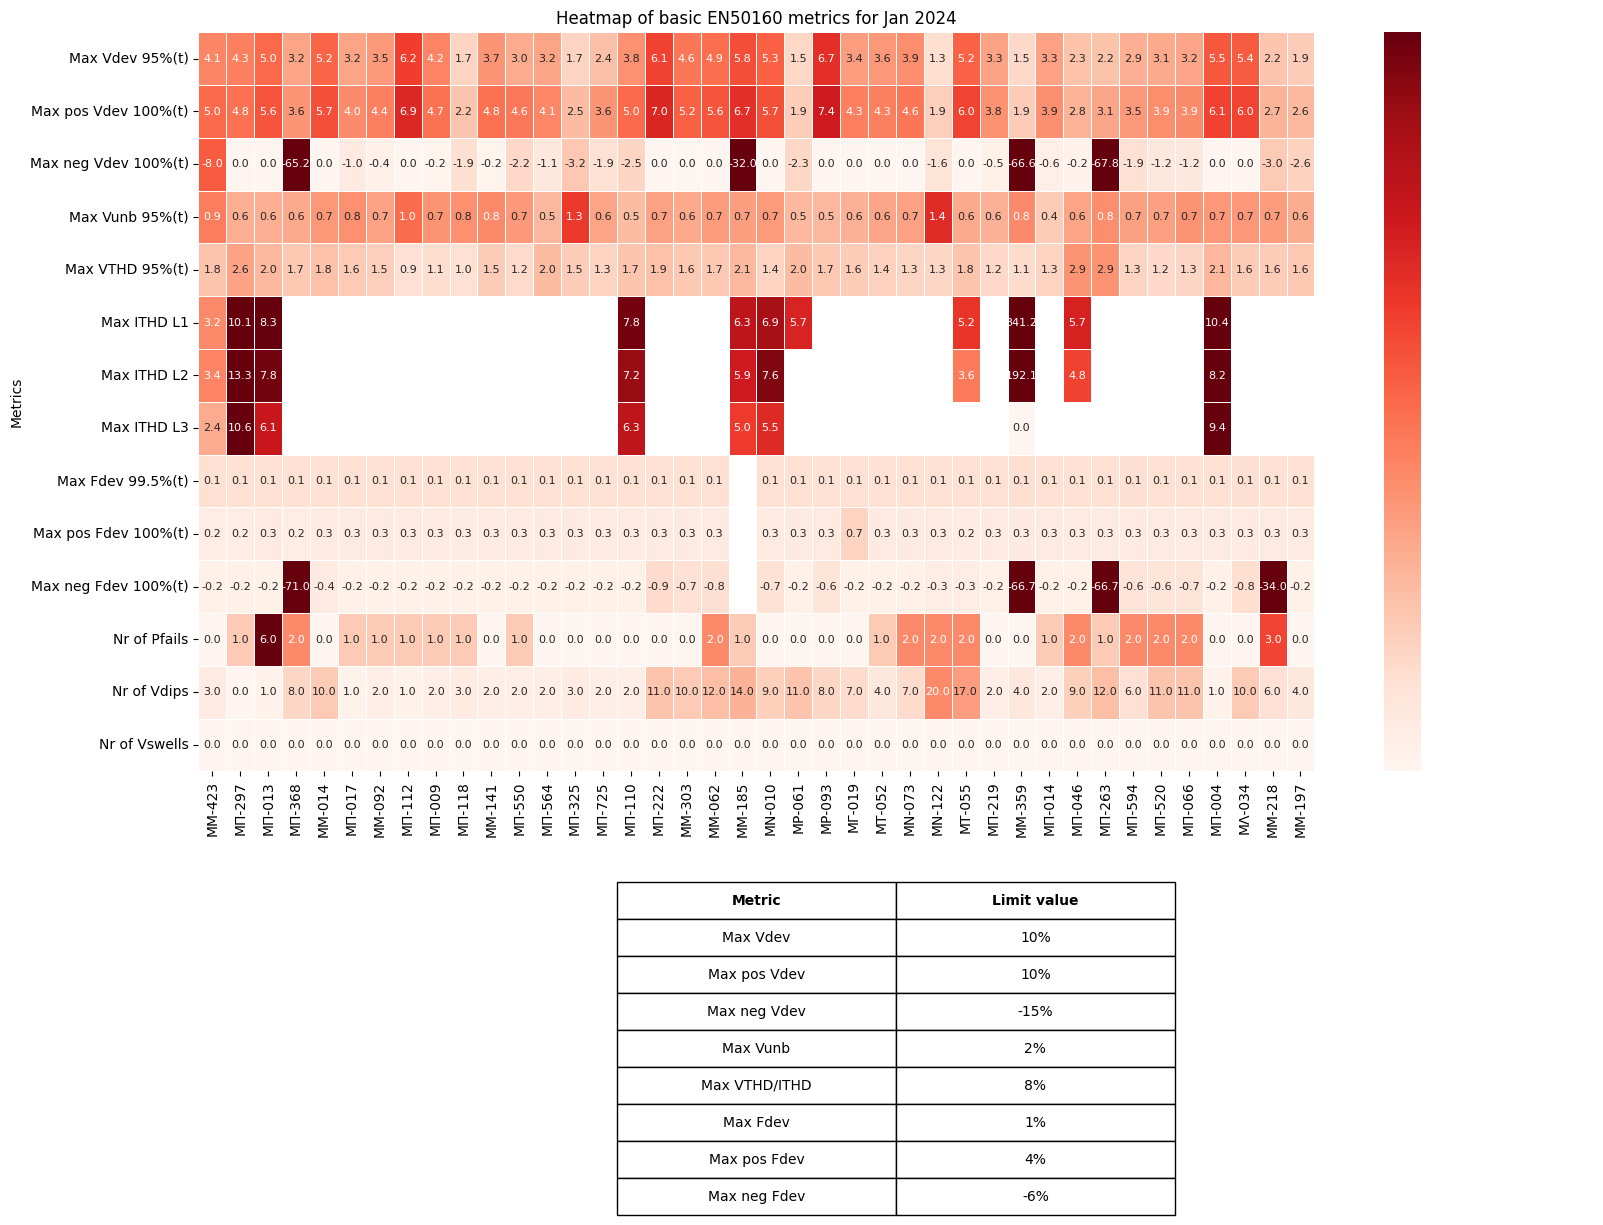

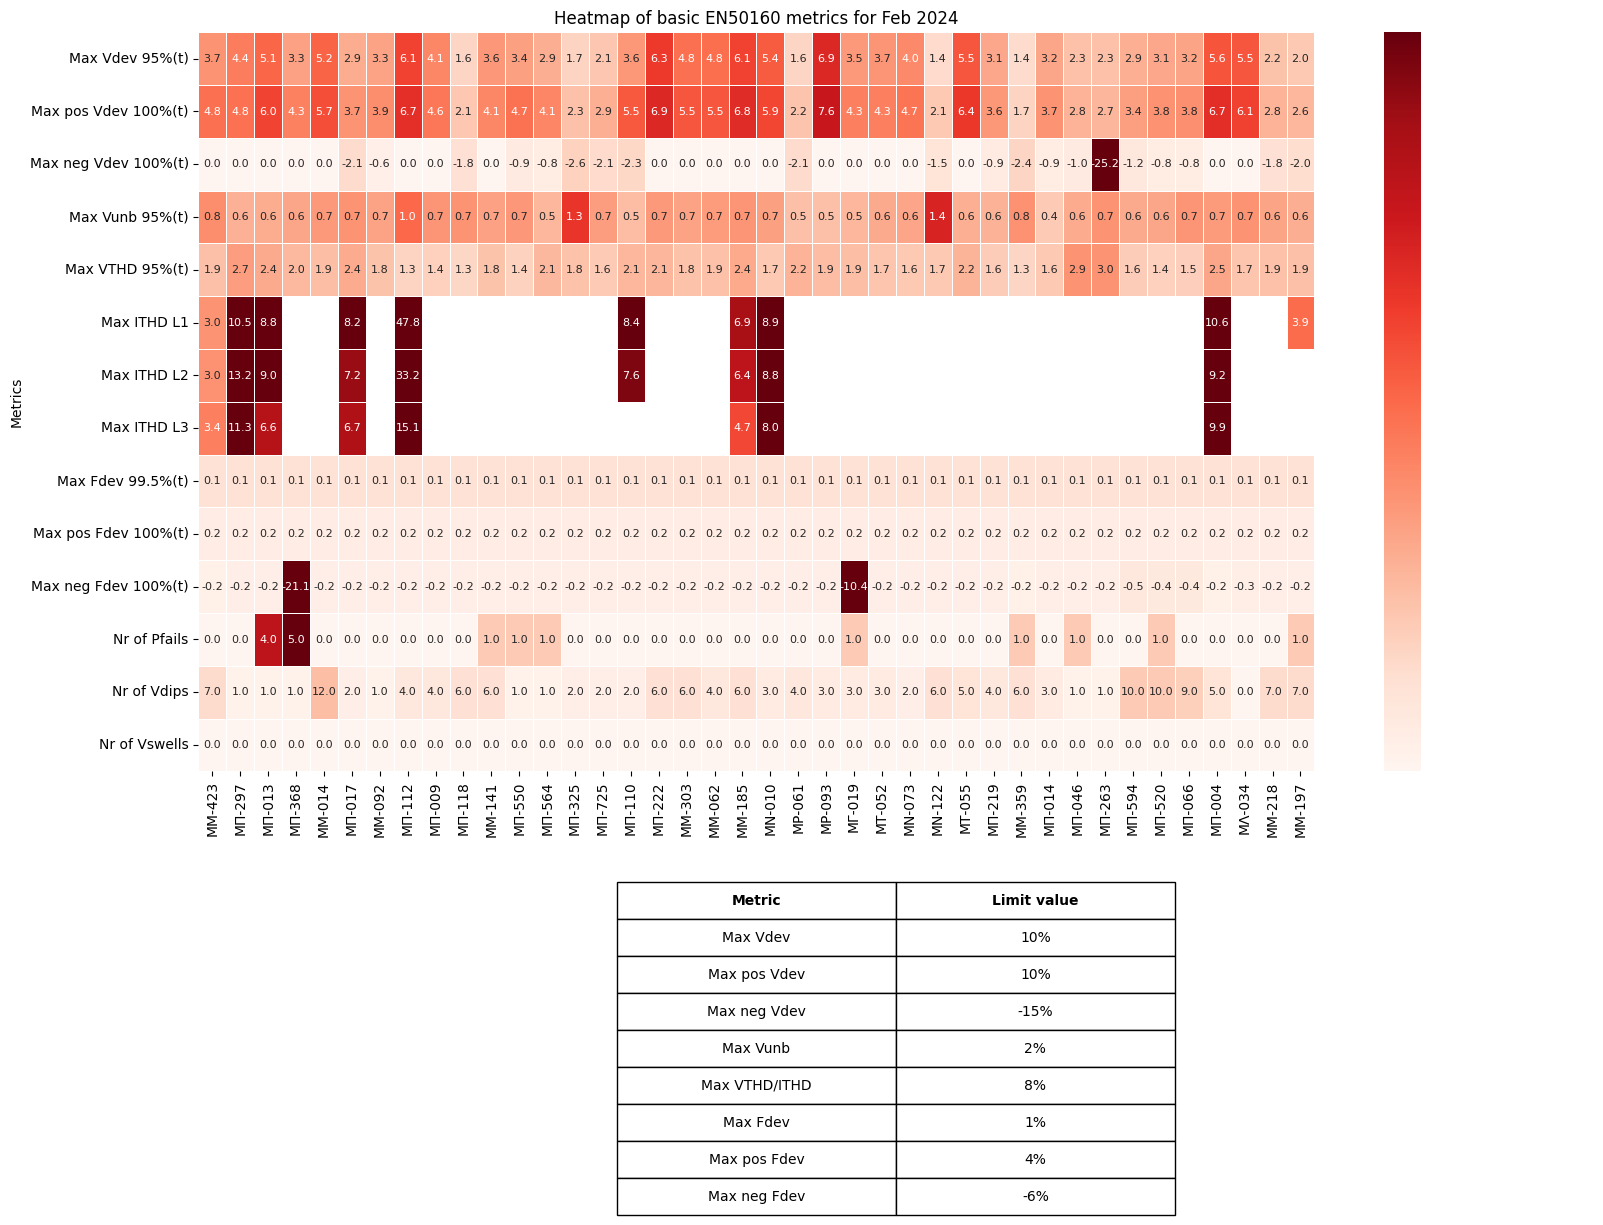

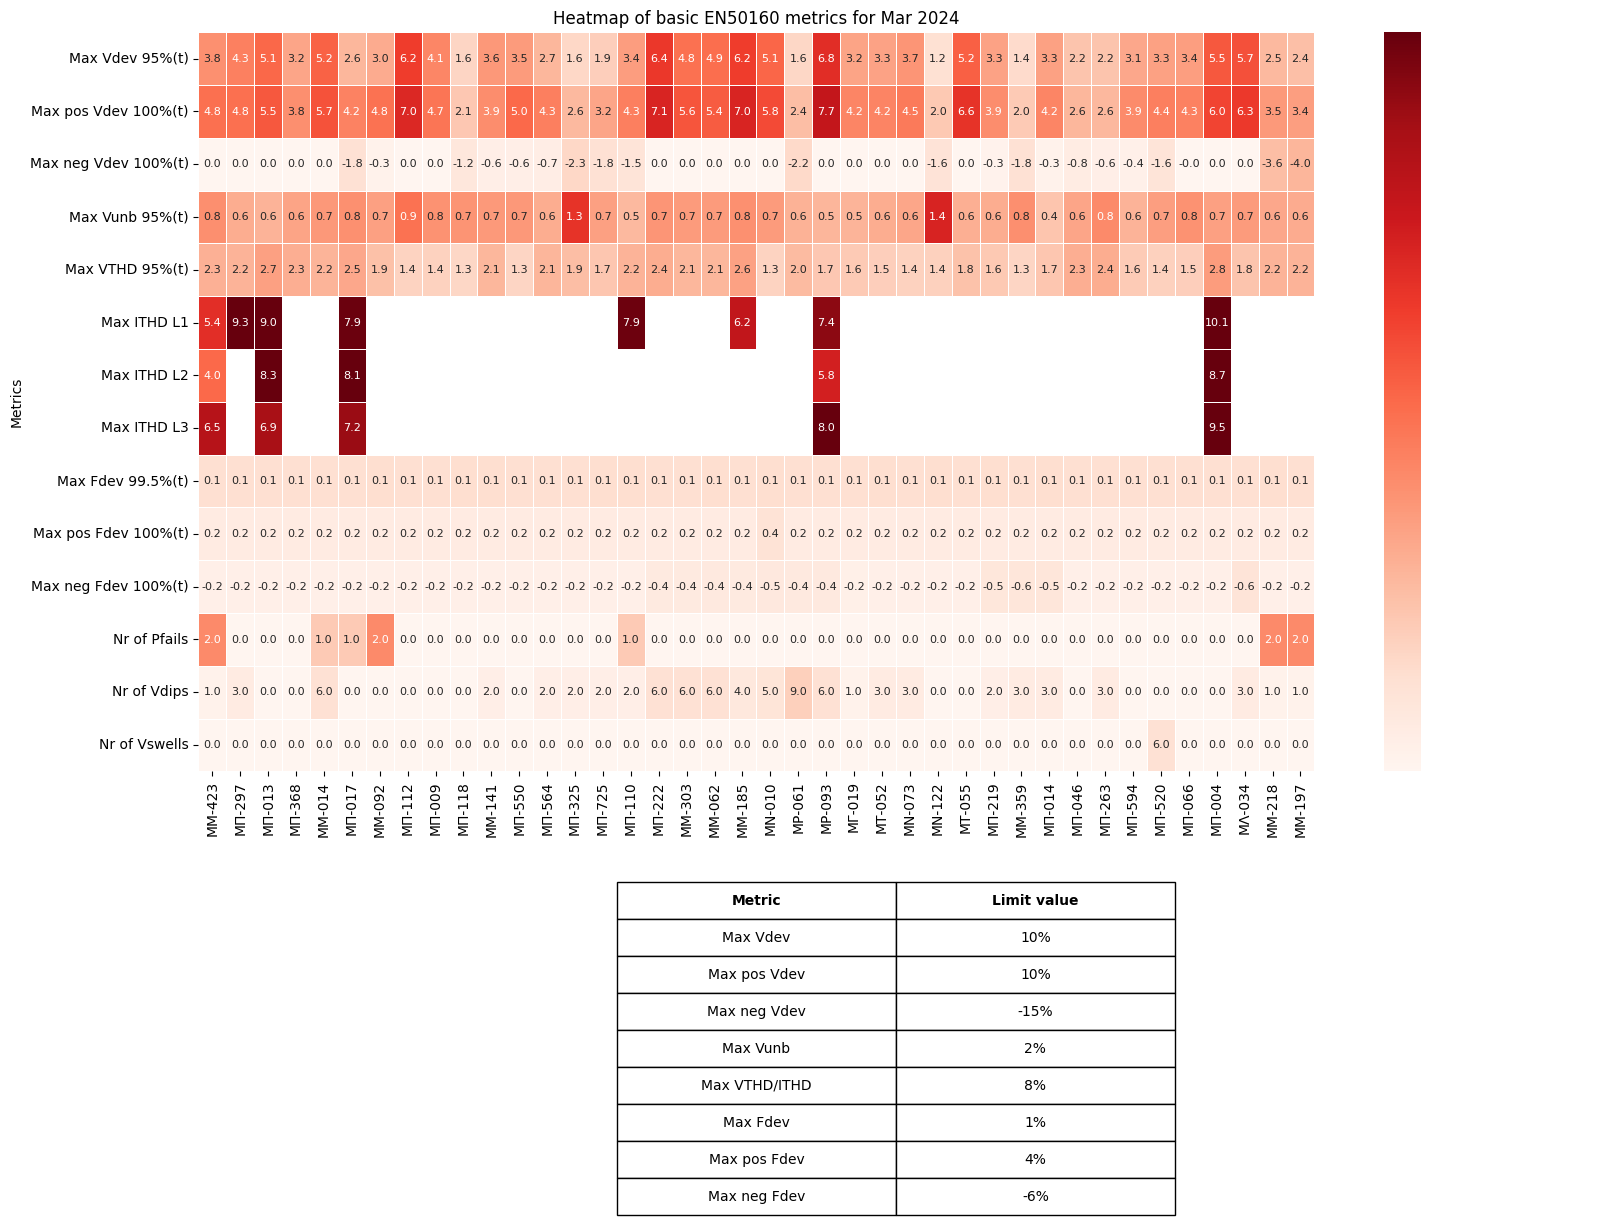

In [5]:
# month = 'May'
year = '2024'


# def normalize_row(x):
#     non_na = x.dropna()
#     if non_na.min() < 0 and non_na.max() <= 0:
#         return (non_na - non_na.max()) / (non_na.min() - non_na.max())  # Reverse normalization for negative-only rows
#     else:
#         # print(non_na,non_na.min(),non_na.max())
#         return (non_na - non_na.min()) / (non_na.max() - non_na.min())
    
for month in ['Jan','Feb','Mar']:#,'Apr','May']:
    df = pd.read_excel('data/HEDNO_KPIs_EN50160_'+str(month)+'_'+str(2024)+'.xlsx', engine='openpyxl')
    df = df.loc[df['Distribution'].isna()]
    df = df.drop(['Installation','Distribution','Latitude','Longitude','Occurences of Frequency over limit','Occurences of Frequency under limit'],axis=1)
    df = df.set_index('Transformer')

    df = df.rename(columns={'Max voltage deviation (95% of 10min intervals)':'Max Vdev 95%(t)',
                            'Max positive voltage deviation (100% of 10min intervals)':'Max pos Vdev 100%(t)',
                            'Max negative voltage deviation (100% of 10min intervals)':'Max neg Vdev 100%(t)',
                            'Max voltage imbalance (95% of 10min intervals)':'Max Vunb 95%(t)',
                            'Max voltage THD (95% of 10min intervals)':'Max VTHD 95%(t)',
                            'Max current THD L1':'Max ITHD L1',
                            'Max current THD L2':'Max ITHD L2',
                            'Max current THD L3':'Max ITHD L3',
                            'Max frequency deviation (99.5% of 10min intervals)':'Max Fdev 99.5%(t)',
                            'Max positive frequency deviation (100% of 10min intervals)':'Max pos Fdev 100%(t)',
                            'Max negative frequency deviation (100% of 10min intervals)':'Max neg Fdev 100%(t)',
                            'Nr. of Power Fails (outage)':'Nr of Pfails',
                            'Nr. of Voltage dips':'Nr of Vdips',
                            'Nr. of Voltage swells':'Nr of Vswells',
                            
                            })
    df.replace('-', np.nan, inplace=True)
    metrics = df.columns.values
    df = df.T
    df_normalized = df.copy()
    for metric in metrics:
        predefined_range = predefined_ranges.get(metric)
        if predefined_range is not None:
            predefined_min, predefined_max = predefined_range
        else:
            predefined_min, predefined_max = None, None
        df_normalized.loc[metric] = normalize_with_predefined_range(df.loc[metric], predefined_min, predefined_max)

    # df_normalized = df.apply(normalize_row, axis=1)
    cols = df_normalized.columns.values
    df = df.reindex(columns=cols)


    # Plot heatmap
    # plt.figure(figsize=(14, 8))
    fig, ax = plt.subplots(2, 1, figsize=(18, 14), gridspec_kw={'height_ratios': [6, 1]})
    # heatmap = sns.heatmap(df_normalized, annot=df,annot_kws={'rotation': 90,'size':8}, fmt=".2f", cmap='Reds', mask=df.isnull(), ax=ax[0])
    heatmap = sns.heatmap(df_normalized, annot=df,annot_kws={'size':8}, fmt=".1f", cmap='Reds', mask=df.isnull(), linewidths=0.5,ax=ax[0])
    ax[0].set_title('Heatmap of basic EN50160 metrics for '+month+' '+year)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Metrics')
    # Remove the tick labels from the color bar
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks([])

    # Create a DataFrame for the acceptable ranges
    ranges_df = pd.DataFrame(list(acceptable_ranges.items()), columns=['Metric', 'Limit value'])
    
    # Hide the second subplot's axes
    ax[1].axis('off')

    # Create a table below the heatmap
    table = ax[1].table(cellText=ranges_df.values, colLabels=ranges_df.columns, cellLoc='center', loc='center')

    # Adjust layout to make room for the table
    plt.subplots_adjust(hspace=0.5)
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5)

    # Make column names bold and fit the contents
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    # Manually set the column widths
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(weight='bold')
        cell.set_fontsize(10)
        cell.set_width(0.2)
        cell.set_height(0.3)
    plt.gca().set_aspect('auto')
    plt.savefig('figures/heatmapEN50160_'+month+'_'+year+'.png', dpi=300)
    # plt.show()

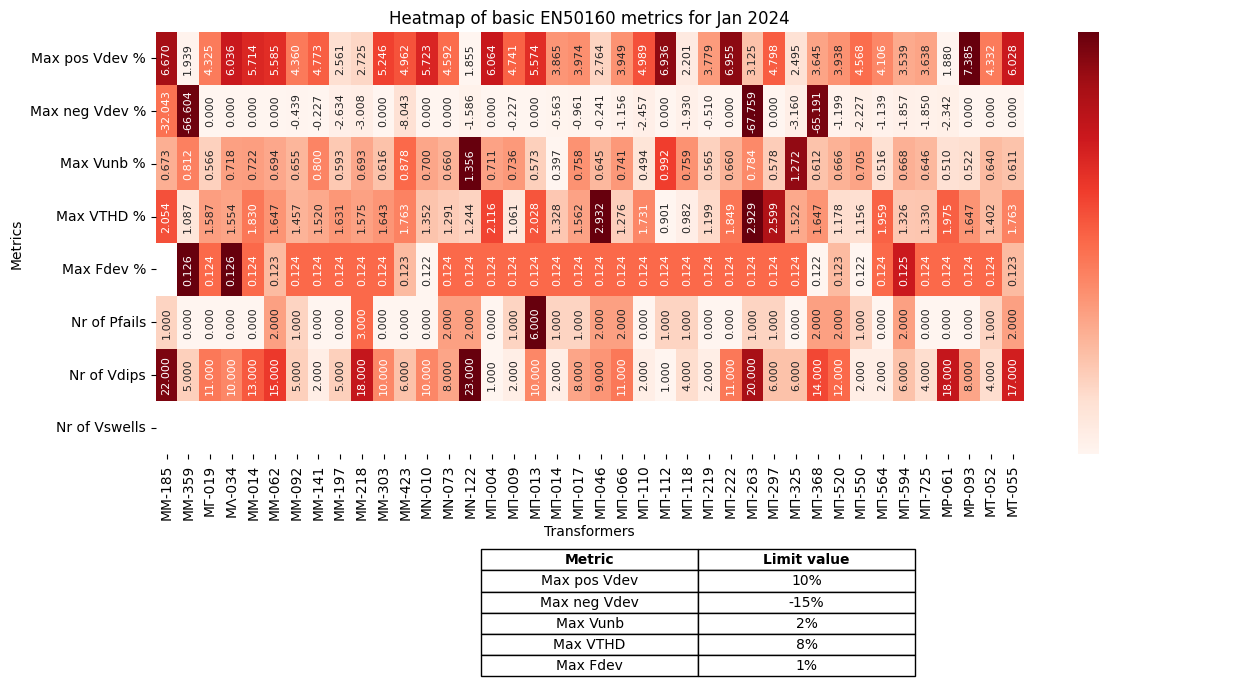

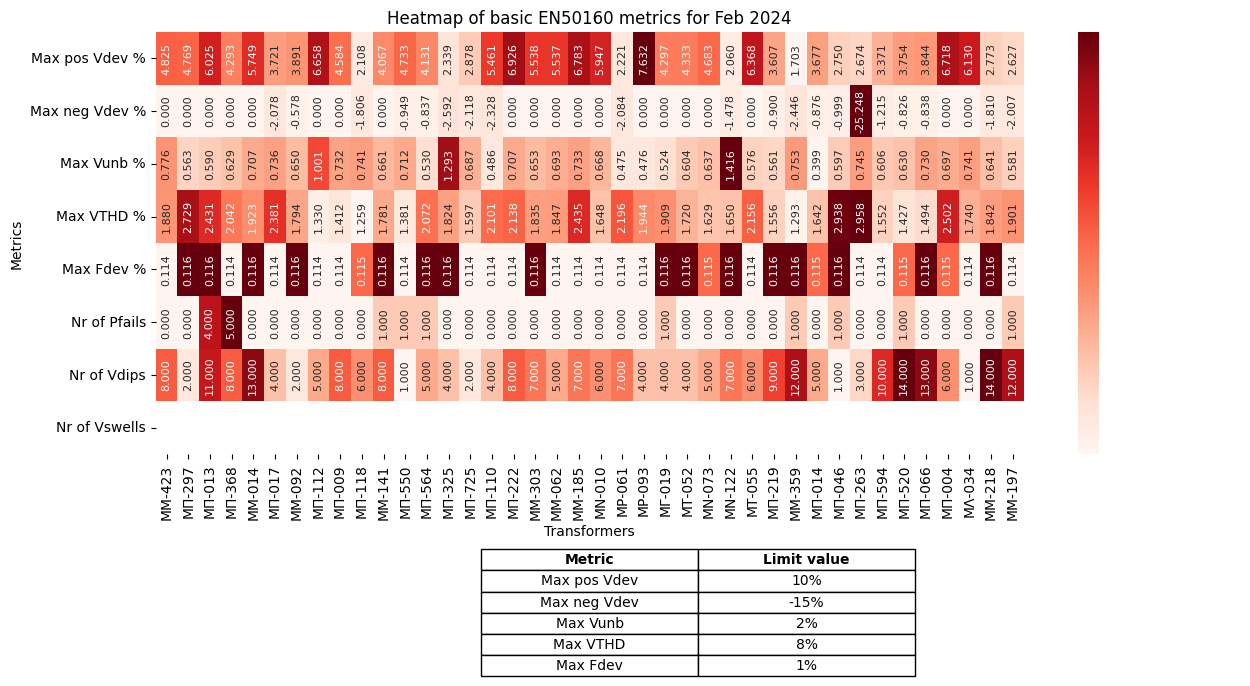

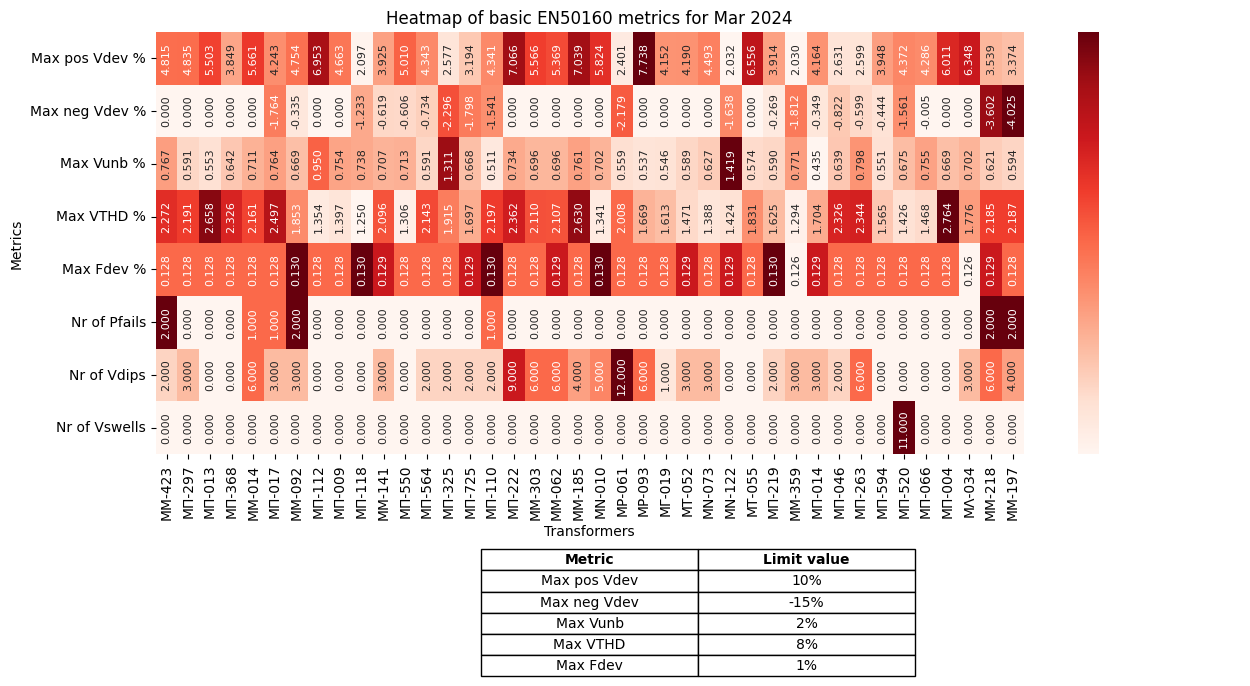

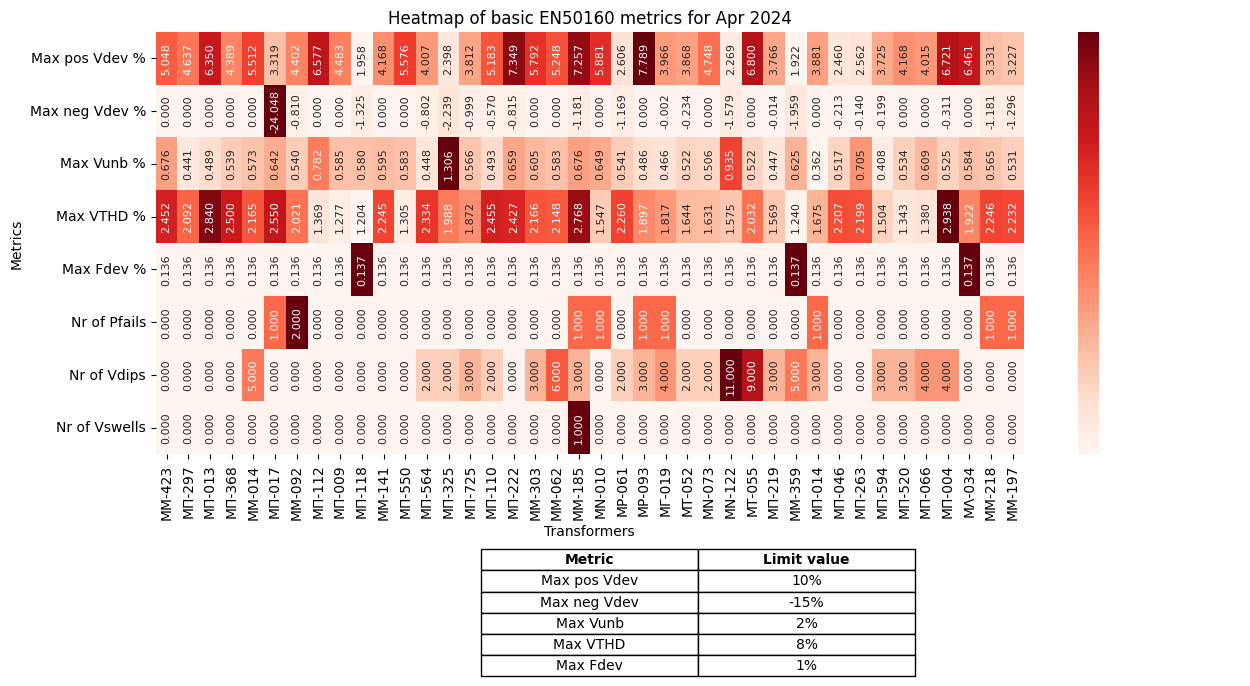

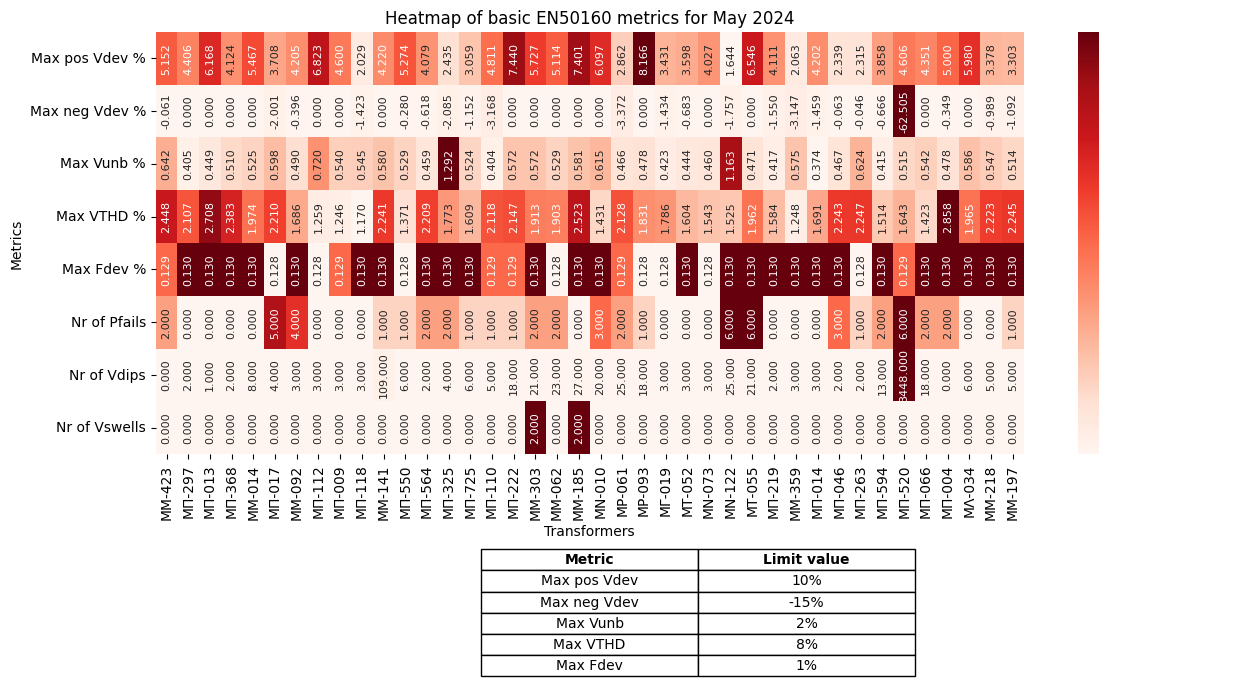

In [22]:
# month = 'May'
year = '2024'


def normalize_row(x):
    non_na = x.dropna()
    if non_na.min() < 0 and non_na.max() <= 0:
        return (non_na - non_na.max()) / (non_na.min() - non_na.max())  # Reverse normalization for negative-only rows
    else:
        # print(non_na,non_na.min(),non_na.max())
        return (non_na - non_na.min()) / (non_na.max() - non_na.min())
    
for month in ['Jan','Feb','Mar','Apr','May']:
    df = pd.read_excel('data/HEDNO_KPIs_EN50160_'+str(month)+'_'+str(2024)+'.xlsx', engine='openpyxl')
    df = df.loc[df['Distribution'].isna()]
    df = df.drop(['Installation','Distribution','Max voltage deviation (95% of 10min intervals)','Max positive frequency deviation (100% of 10min intervals)','Max negative frequency deviation (100% of 10min intervals)','Latitude','Longitude','Occurences of Frequency over limit','Occurences of Frequency under limit'],axis=1)
    df = df.set_index('Transformer')

    df = df.rename(columns={'Max positive voltage deviation (100% of 10min intervals)':'Max pos Vdev %',
                            'Max negative voltage deviation (100% of 10min intervals)':'Max neg Vdev %',
                            'Max voltage imbalance (95% of 10min intervals)':'Max Vunb %',
                            'Max voltage THD (95% of 10min intervals)':'Max VTHD %',
                            'Max frequency deviation (99.5% of 10min intervals)':'Max Fdev %',
                            'Nr. of Power Fails (outage)':'Nr of Pfails',
                            'Nr. of Voltage dips':'Nr of Vdips',
                            'Nr. of Voltage swells':'Nr of Vswells',
                            
                            })
    df.replace('-', np.nan, inplace=True)
    df = df.T
    df_normalized = df.apply(normalize_row, axis=1)
    cols = df_normalized.columns.values
    df = df.reindex(columns=cols)


    # Plot heatmap
    # plt.figure(figsize=(14, 8))
    fig, ax = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [6, 1]})

    heatmap = sns.heatmap(df_normalized, annot=df,annot_kws={'rotation': 90,'size':8}, fmt=".3f", cmap='Reds', mask=df.isnull(), ax=ax[0])
    ax[0].set_title('Heatmap of basic EN50160 metrics for '+month+' '+year)
    ax[0].set_xlabel('Transformers')
    ax[0].set_ylabel('Metrics')
    # Remove the tick labels from the color bar
    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks([])

    # Create a DataFrame for the acceptable ranges
    ranges_df = pd.DataFrame(list(acceptable_ranges.items()), columns=['Metric', 'Limit value'])

    # Hide the second subplot's axes
    ax[1].axis('off')

    # Create a table below the heatmap
    table = ax[1].table(cellText=ranges_df.values, colLabels=ranges_df.columns, cellLoc='center', loc='center')

    # Adjust layout to make room for the table
    plt.subplots_adjust(hspace=0.5)
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5)

    # Make column names bold and fit the contents
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    # Manually set the column widths
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(weight='bold')
        cell.set_fontsize(10)
        cell.set_width(0.2)
        cell.set_height(0.3)
    # plt.savefig('heatmapEN50160_'+month+'_'+year+'.png', dpi=300)
    plt.show()